# Install

In [1]:
!pip install pycaret --quiet
!pip install catboost --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.4/60.4 kB 1.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 163.8/163.8 kB 5.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.4/50.4 kB 1.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 486.1/486.1 kB 6.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.8/106.8 kB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.8/21.8 MB 20.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.9/81.9 kB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.2/302.2 kB 15.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.9/79.9 MB 9.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 80.7/80.7 kB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 71.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.1/12.1 MB 94.5 MB/s eta 0:00:00
   ━━━━

# Imports

In [2]:
import numpy as np
import pandas as pd
from pycaret.datasets import get_data
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import r2_score, mean_absolute_error
from catboost import CatBoostRegressor
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
from tqdm import tqdm

# Utils

In [3]:
def get_dataset(dataset_name):
    """Get dataset."""
    target_name = datasets.loc[datasets["Dataset"]==dataset_name, "Target Variable 1"]
    df = get_data(dataset_name, verbose=False).reset_index(drop=True)
    X, y = df.drop(target_name, axis=1), df[target_name]
    y = y.replace({yval: binval for yval, binval in zip(y.value_counts().index, [0,1])}).iloc[:,0]
    num_features = X.columns[X.apply(is_numeric)].tolist()
    cat_features = [c for c in X.columns if c not in num_features]
    X[cat_features] = X[cat_features].fillna({feature: "NULL" for feature in cat_features})
    return X, y, num_features, cat_features

def is_numeric(x):
    """Check whether an object is numeric."""
    try:
      x+0
      return True
    except:
      return False

def float2kdollars(value, tick_number=None):
    return f"$ {int(round(value/1000))}{'k' if abs(value) > 0 else ''}"

# Load data, train models, measure metrics

In [4]:
random_state = 4

datasets = get_data(verbose=False)

X_full, y_full, num_features, cat_features = get_dataset("house")
X_full[["square feet", "overall condition"]] = X_full[["GrLivArea","OverallCond"]]
y_full.name = "house sale price"
X, y, pred = {}, {}, {}
y["train"], y["test"] = train_test_split(y_full[y_full>10_000], train_size=.5, random_state=random_state)
X["train"], X["test"] = X_full.loc[y["train"].index, ["square feet", "overall condition"]], X_full.loc[y["test"].index, ["square feet", "overall condition"]]

model = {
    "catboost": CatBoostRegressor(random_seed=random_state, silent=True),
    "catboost with monotonic constraints": CatBoostRegressor(random_seed=random_state, silent=True, monotone_constraints={"square feet": 1, "overall condition": 1}),
    "decision tree": DecisionTreeRegressor(max_depth=3, min_samples_leaf=10, random_state=random_state),
    "decision tree with monotonic constraints": DecisionTreeRegressor(max_depth=3, min_samples_leaf=10, random_state=random_state, monotonic_cst=[1,1]),
    "linear regression": LinearRegression(),
}

for s in ["train", "test"]:

    if s == "train":
        model = {
            model_name: model[model_name].fit(X["train"], y["train"])
            for model_name in model.keys()
        }

    pred[s] = {
        model_name: pd.Series(model[model_name].predict(X[s]), index=y[s].index)
        for model_name in model.keys()
    }

results = pd.DataFrame()

for sample in y.keys():
    for metric_name, metric in zip(["MAE", "R^2"], [mean_absolute_error, r2_score]):
        for model_name in model.keys():
            results.loc[sample, f"{metric_name}({model_name})"] = metric(y_true=y[sample], y_pred=pred[sample][model_name])

results_format = results.apply(lambda col:
    col.apply(lambda x: f"{x:.1%}" if "R^2(" in col.name else (f"$ {x:,.0f}" if "MAE(" in col.name else x)))

# Display

In [5]:
example = pd.concat([X["train"], y["train"]], axis=1).tail()
example["square feet"] = example["square feet"].apply(lambda x: f"{x:,.0f}")
example["house sale price"] = example["house sale price"].apply(lambda x: float2kdollars(x))
example

,square feet,overall condition,house sale price
366,"1,394",5,$ 159k
726,"1,680",9,$ 222k
446,"1,888",6,$ 190k
176,"2,060",5,$ 211k
1178,"1,343",6,$ 155k


In [6]:
example = pd.DataFrame([[3_000, 5], [3_000, 7]], columns=X["train"].columns, index=["house", "house after renovation"])
for model_name in ["catboost", "decision tree", "linear regression"]:
    example[f"predicted {y['train'].name} ({model_name})"] = [float2kdollars(pred) for pred in model[model_name].predict(example[X["train"].columns])]
example["square feet"] = example["square feet"].apply(lambda x: f"{x:,.0f}")
example

,square feet,overall condition,predicted house sale price (catboost),predicted house sale price (decision tree),predicted house sale price (linear regression)
house,"3,000",5,$ 427k,$ 360k,$ 340k
house after renovation,"3,000",7,$ 252k,$ 247k,$ 332k


In [7]:
results_format

,MAE(catboost),MAE(catboost with monotonic constraints),MAE(decision tree),MAE(decision tree with monotonic constraints),MAE(linear regression),R^2(catboost),R^2(catboost with monotonic constraints),R^2(decision tree),R^2(decision tree with monotonic constraints),R^2(linear regression)
train,"$ 27,371","$ 35,442","$ 36,359","$ 37,641","$ 38,100",72.0%,55.3%,53.2%,52.0%,48.6%
test,"$ 35,609","$ 35,067","$ 39,636","$ 38,426","$ 37,988",53.2%,57.3%,45.1%,51.0%,52.1%


# Plots

In [8]:
df = X["train"].astype(np.float32)

xlim_global = np.array([df.iloc[:,0].min() - (df.iloc[:,0].max() - df.iloc[:,0].min()) * .1, df.iloc[:,0].max() + (df.iloc[:,0].max() - df.iloc[:,0].min()) * .1])
ylim_global = np.array([df.iloc[:,1].min() - (df.iloc[:,1].max() - df.iloc[:,1].min()) * .1, df.iloc[:,1].max() + (df.iloc[:,1].max() - df.iloc[:,1].min()) * .1])

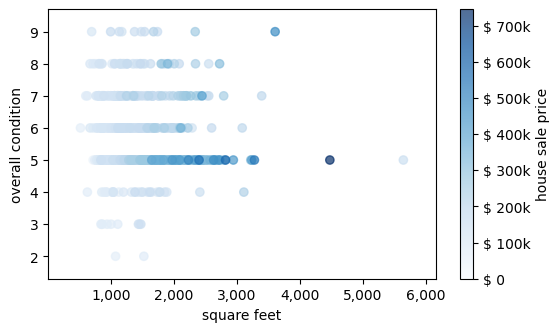

In [9]:
fig, ax = plt.subplots(figsize=(6.25, 3.5))

sp = ax.scatter(
    df.loc[y["train"].sort_values().index].iloc[:,0], df.loc[y["train"].sort_values().index].iloc[:,1],
    c=y["train"].sort_values(), alpha=.7, cmap="Blues", vmin=0, vmax=y["train"].max())
cbar = plt.colorbar(sp, ax=ax)
cbar.set_label(y["train"].name)
cbar.ax.yaxis.set_major_formatter(FuncFormatter(float2kdollars))

ax.set_xticks(range(1_000, 7_000, 1_000), [f"{x:,.0f}" for x in range(1_000, 7_000, 1_000)])
ax.set_xlim(xlim_global)
ax.set_ylim(ylim_global)
ax.set_xlabel(X["train"].columns[0])
ax.set_ylabel(X["train"].columns[1])

fig.savefig("raw_data_scatterplot.png", dpi=200, bbox_inches="tight")

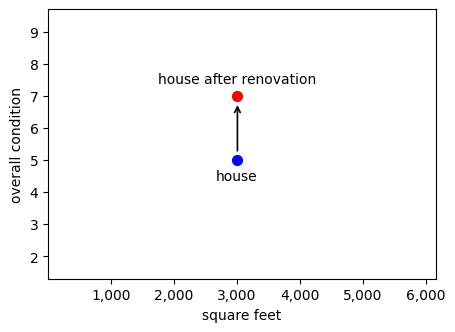

In [10]:
fig, ax = plt.subplots(figsize=(5, 3.5))

ax.scatter(3_000, 5, s=50, zorder=5, color="blue")
ax.scatter(3_000, 7, s=50, zorder=5, color="red")
ax.annotate("house", [3_000, 5-.3], ha="center", va="top")
ax.annotate("house after renovation", [3_000, 7+.3], ha="center", va="bottom")
ax.annotate("", xy=(3_000+10, 7-.2), xytext=(3_000+10, 5+.2), arrowprops=dict(arrowstyle="->", lw=1.2, color="black"))
ax.set_xticks(range(1_000, 7_000, 1_000), [f"{x:,.0f}" for x in range(1_000, 7_000, 1_000)])
ax.set_xlim(xlim_global)
ax.set_ylim(ylim_global)
ax.set_xlabel(X["train"].columns[0])
ax.set_ylabel(X["train"].columns[1])

fig.savefig("single_house_scatterplot.png", dpi=200, bbox_inches="tight")

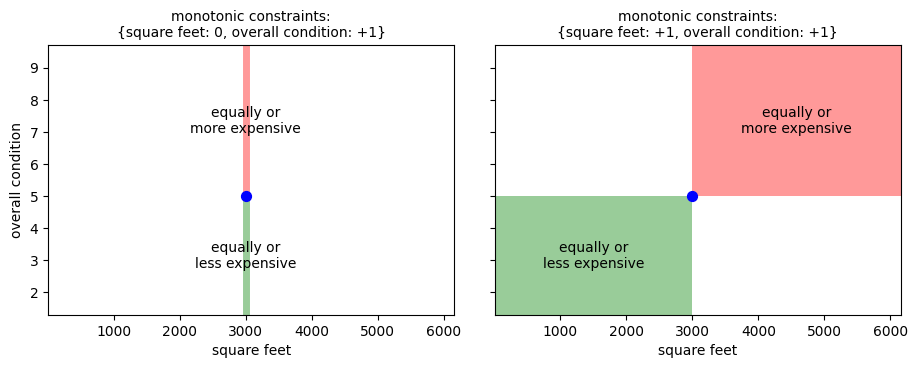

In [11]:
fig, axs = plt.subplots(1, 2, figsize=(5*2 + 1, 3.5), sharex=True, sharey=True)
plt.subplots_adjust(wspace=.10)

for en_occ, occ in enumerate(["+1"]):
    for en_sfc, sfc in enumerate(["0", "+1"]):

        ax = axs[en_sfc]
        ax.scatter(3_000, 5, s=50, zorder=5, color="blue")

        xlim_red_rectangle = [3_000, xlim_global[0] if sfc == "-1" else (xlim_global[1] if sfc == "+1" else 3_000)]
        ylim_red_rectangle = [5, ylim_global[0] if occ == "-1" else (ylim_global[1] if occ == "+1" else 5)]
        ax.fill_between(xlim_red_rectangle, ylim_red_rectangle[0], ylim_red_rectangle[1], facecolor="red", edgecolor="red", alpha=.4, linewidth=5 if occ == "0" or sfc == "0" else 0)
        ax.annotate("equally or\nmore expensive", [np.mean(xlim_red_rectangle), np.mean(ylim_red_rectangle)], ha="center", va="center") if occ != "0" or sfc != "0" else None

        xlim_green_rectangle = [3_000, xlim_global[1] if sfc == "-1" else (xlim_global[0] if sfc == "+1" else 3_000)]
        ylim_green_rectangle = [5, ylim_global[1] if occ == "-1" else (ylim_global[0] if occ == "+1" else 5)]
        ax.fill_between(xlim_green_rectangle, ylim_green_rectangle[0], ylim_green_rectangle[1], color="green", edgecolor="green", alpha=.4, linewidth=5 if occ == "0" or sfc == "0" else 0)
        ax.annotate("equally or\nless expensive", [np.mean(xlim_green_rectangle), np.mean(ylim_green_rectangle)], ha="center", va="center") if occ != "0" or sfc != "0" else None

        ax.set_title(f"monotonic constraints:\n{{square feet: {sfc}, overall condition: {occ}}}", fontsize=10)
        ax.set_xlim(xlim_global)
        ax.set_ylim(ylim_global)
        ax.set_ylabel(X["train"].columns[1]) if en_sfc == 0 else None
        ax.set_xlabel(X["train"].columns[0])

fig.savefig("constraint_combinations.png", dpi=200, bbox_inches="tight")

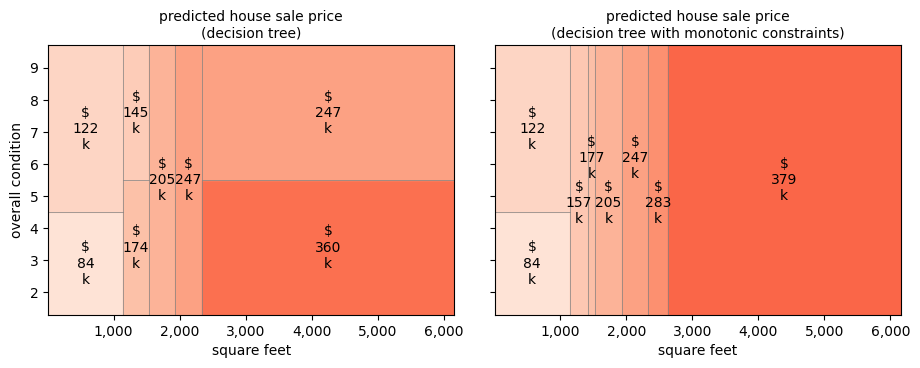

In [12]:
fig, axs = plt.subplots(1, 2, figsize=(5*2 + 1, 3.5), sharex=True, sharey=True)
plt.subplots_adjust(wspace=.10)

for en_ax, model_name in enumerate(["decision tree", "decision tree with monotonic constraints"]):

    ax = axs[en_ax]

    tree = model[model_name].tree_
    xlim = np.stack([xlim_global] * tree.node_count)
    ylim = np.stack([ylim_global] * tree.node_count)

    for en, (f, t, cl, cr) in enumerate(zip(tree.feature, tree.threshold, tree.children_left, tree.children_right)):

        if cl > 0:
            xlim[cl] = xlim[en]; ylim[cl] = ylim[en]
        if cr > 0:
            xlim[cr] = xlim[en]; ylim[cr] = ylim[en]

        if f == 0:
            xlim[cl,1] = t; xlim[cr,0] = t
            ax.plot([t] * 2, ylim[en], lw=.5, label=en, color="grey")
        elif f == 1:
            ylim[cr,0] = t; ylim[cl,1] = t
            ax.plot(xlim[en], [t] * 2, lw=.5, label=en, color="grey")
        else:
            ax.fill_between(xlim[en], ylim[en, 0], ylim[en, 1], color=plt.cm.Reds(tree.value.reshape(-1)[en]/y["train"].max()), zorder=-1)
            if en_ax == 1 and round(tree.value.reshape(-1)[en] / 1000) in (157, 205, 283):
                ycoords = np.mean(ylim[en]) - .7
            elif en_ax == 1 and round(tree.value.reshape(-1)[en] / 1000) in (177, 247):
                ycoords = np.mean(ylim[en]) + .7
            else:
                ycoords = np.mean(ylim[en])
            ax.annotate(f"$\n{round(tree.value.reshape(-1)[en] / 1000)}\nk", [np.mean(xlim[en]), ycoords], ha="center", va="center")

    ax.set_xticks(range(1_000, 7_000, 1_000), [f"{x:,.0f}" for x in range(1_000, 7_000, 1_000)])
    ax.set_xlim(xlim_global)
    ax.set_ylim(ylim_global)
    ax.set_xlabel(X["train"].columns[0])
    ax.set_ylabel(X["train"].columns[1]) if en_ax == 0 else None
    ax.set_title(f"predicted {y['train'].name}\n({model_name})", fontsize=10)

fig.savefig("decision_tree_heatmap.png", dpi=200, bbox_inches="tight")

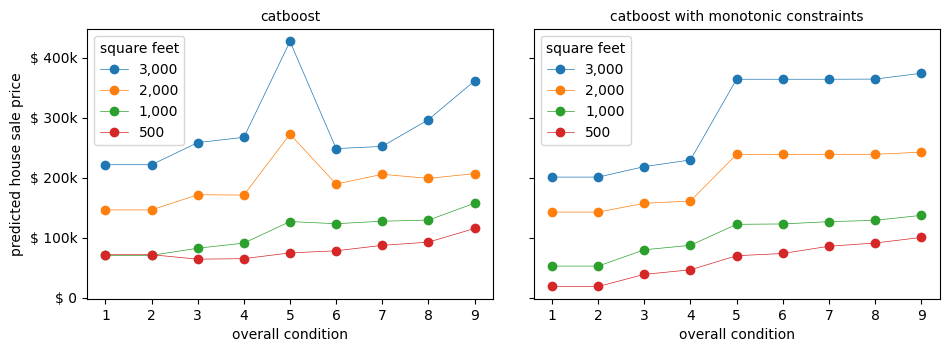

In [13]:
fig, axs = plt.subplots(1, 2, figsize=(5*2 + 1, 3.5), sharex=True, sharey=True)
plt.subplots_adjust(wspace=.10)

for en_ax, model_name in enumerate(["catboost", "catboost with monotonic constraints"]):
    ax = axs[en_ax]
    for square_feet in [3_000, 2_000, 1_000, 500]:
        ax.plot(range(1, 10), model[model_name].predict([[square_feet, overall_condition] for overall_condition in range(1, 10)]), marker='o', lw=.5, label=f"{square_feet:,.0f}")
    ax.set_title(model_name, fontsize=10)
    ax.set_xticks(range(1,10))
    ax.set_xlabel("overall condition")
    ax.legend(title = "square feet")
    ax.set_ylabel(f"predicted {y['train'].name}") if en_ax == 0 else None
    ax.set_yticks(range(0, 500_000, 100_000), [float2kdollars(y) for y in range(0, 500_000, 100_000)]) if en_ax == 0 else None

fig.savefig("catboost_simulation.png", dpi=200, bbox_inches="tight")